In [1]:
!pip install rdkit

In [2]:
!pip install rdkit-pypi
!pip install matplotlib

In [3]:
!pip install torch

In [4]:
!pip install torch_geometric

In [5]:
!pip install torchvision

In [6]:
!pip install pytorch-lightning

In [7]:
!pip install deepchem

In [8]:
!pip install pytorch-lightning

In [9]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdchem
import torch
from torch_geometric.data import Data


In [10]:
import os
import csv
import glob
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data

In [11]:
from typing import List, Tuple
import numpy as np

from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol
from deepchem.feat.graph_data import GraphData
from deepchem.feat.base_classes import MolecularFeaturizer
from deepchem.utils.molecule_feature_utils import one_hot_encode
from deepchem.utils.molecule_feature_utils import get_atom_type_one_hot
from deepchem.utils.molecule_feature_utils import construct_hydrogen_bonding_info
from deepchem.utils.molecule_feature_utils import get_atom_hydrogen_bonding_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_hybridization_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_total_num_Hs_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_is_in_aromatic_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_chirality_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge
from deepchem.utils.molecule_feature_utils import get_atom_partial_charge
from deepchem.utils.molecule_feature_utils import get_atom_total_degree_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_type_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_in_same_ring_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_conjugated_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_stereo_one_hot

In [12]:
# from deepchem.utils.molecule_feature_utils import get_atom_formal_charge_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_implicit_valence_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_explicit_valence_one_hot
# from deepchem.utils.rdkit_utils import compute_all_pairs_shortest_path
# from deepchem.utils.rdkit_utils import compute_pairwise_ring_info

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
DEFAULT_ATOM_TYPE_SET = [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
]
DEFAULT_HYBRIDIZATION_SET = ["SP", "SP2", "SP3"]
DEFAULT_TOTAL_NUM_Hs_SET = [0, 1, 2, 3, 4]
DEFAULT_FORMAL_CHARGE_SET = [-2, -1, 0, 1, 2]
DEFAULT_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5]
DEFAULT_RING_SIZE_SET = [3, 4, 5, 6, 7, 8]
DEFAULT_BOND_TYPE_SET = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]
DEFAULT_BOND_STEREO_SET = ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]
DEFAULT_GRAPH_DISTANCE_SET = [1, 2, 3, 4, 5, 6, 7]
DEFAULT_ATOM_IMPLICIT_VALENCE_SET = [0, 1, 2, 3, 4, 5, 6]
DEFAULT_ATOM_EXPLICIT_VALENCE_SET = [1, 2, 3, 4, 5, 6]

USER_ATOM_TYPE_SET  = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
       'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag',
       'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
       'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb']
USER_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
USER_HYBRIDIZATION_SET = ["SP", "SP2", "SP3", 'SP3D','SP3D2']

In [15]:
def one_hot_encode(value, allowed_values, include_unknown_set=False):
    """Create a one-hot encoded vector based on allowed values."""
    if include_unknown_set and value not in allowed_values:
        value = allowed_values[-1]

    return [1.0 if v == value else 0.0 for v in allowed_values]


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
from torch_geometric.data import Data

class MolGraphConvFeaturizer:
    def __init__(self, use_edges=True, use_chirality=True, use_partial_charge=True):
        self.use_edges = use_edges
        self.use_chirality = use_chirality
        self.use_partial_charge = use_partial_charge

    def featurize(self, smiles):
        # Convert SMILES to RDKit Mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Compute Gasteiger charges if necessary
        if self.use_partial_charge:
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                return None  # Unable to compute charges for this molecule

        # Get atom features
        atom_features = np.array([self._get_atom_features(atom) for atom in mol.GetAtoms()])

        # Get bond features and indices
        if self.use_edges:
            edge_indices, edge_features = self._get_bond_features(mol)
        else:
            edge_indices, edge_features = None, None

        # Create a graph data object
        graph = Data(x=torch.tensor(atom_features, dtype=torch.float),
                     edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices is not None else None,
                     edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)

        return graph

    def _get_atom_features(self, atom):
        # One-hot encoding of atom type
        atom_type = one_hot_encode(atom.GetSymbol(), USER_ATOM_TYPE_SET, include_unknown_set=True)

        # Formal charge of the atom
        formal_charge = get_atom_formal_charge(atom)

        # One-hot encoding of the atom's hybridization
        hybridization = get_atom_hybridization_one_hot(atom, USER_HYBRIDIZATION_SET, include_unknown_set=True)

        # Aromaticity of the atom
        aromatic = get_atom_is_in_aromatic_one_hot(atom)

        # One-hot encoding of the atom's degree
        degree = get_atom_total_degree_one_hot(atom, USER_TOTAL_DEGREE_SET, include_unknown_set=True)

        # One-hot encoding of the total number of hydrogens connected to the atom
        total_num_Hs = get_atom_total_num_Hs_one_hot(atom, DEFAULT_TOTAL_NUM_Hs_SET, include_unknown_set=True)

        # Concatenating all the features
        atom_feat = np.concatenate([
            atom_type, formal_charge, hybridization, aromatic, degree, total_num_Hs
        ])

        if self.use_chirality:
            chirality = get_atom_chirality_one_hot(atom)
            atom_feat = np.concatenate([atom_feat, chirality])

        if self.use_partial_charge:
            partial_charge = get_atom_partial_charge(atom)
            atom_feat = np.concatenate([atom_feat, partial_charge])

        return atom_feat

    def _get_bond_features(self, mol):
        # Initialize lists for source and destination atoms of each bond
        src, dest, bond_features = [], [], []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            src += [start, end]
            dest += [end, start]

            # Extract bond features and duplicate for both bond directions
            bond_feat = self._extract_bond_features(bond)
            bond_features += [bond_feat, bond_feat]

        edge_indices = [src, dest]
        print("edge_indices : ",edge_indices)
        print("bond_features : ",bond_features)
        return edge_indices, bond_features
        
    def _extract_bond_features(self, bond):
        """
        Extract bond features from a RDKit bond object.
        """

        # One-hot encoding of bond type
        bond_type = one_hot_encode(bond.GetBondTypeAsDouble(), [1.0, 1.5, 2.0, 3.0], include_unknown_set=True)

        # Whether the bond is in the same ring
        same_ring = [1.0] if bond.IsInRing() else [0.0]

        # Whether the bond is conjugated
        conjugated = [1.0] if bond.GetIsConjugated() else [0.0]

        # One-hot encoding of bond stereo configuration
        stereo = one_hot_encode(bond.GetStereo(), [Chem.rdchem.BondStereo.STEREONONE, 
                                                   Chem.rdchem.BondStereo.STEREOANY, 
                                                   Chem.rdchem.BondStereo.STEREOZ, 
                                                   Chem.rdchem.BondStereo.STEREOE], 
                                include_unknown_set=True)

        # Concatenate all bond features
        bond_feat = np.concatenate([bond_type, same_ring, conjugated, stereo])

        return bond_feat        


In [17]:
# Example usage
#featurizer = MolGraphConvFeaturizer()
#graph = featurizer.featurize('CCO')  # Example SMILES string
#print(type(graph))
#print((graph))

In [18]:
## Assuming graphs[0] is a torch_geometric.data.Data object from your graphs list

## Print node features
#print("Len of graph:", len(graph))
#print("Node Features:")
#for i, node_feature in enumerate(graph.x):
#    print(f"Node {i}: {node_feature}")

## Print edge pairs and edge features
#print("\nEdge Pairs and Features:")
#for i, edge in enumerate(graph.edge_index.t()):
#    src, dest = edge[0].item(), edge[1].item()
#    edge_feature = graph.edge_attr[i]
#    print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


In [19]:
#graph.is_directed()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def visualize_graph(data):
    # Create a networkx graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(data.num_nodes):
        G.add_node(i)

    # Add edges to the graph
    edge_index = data.edge_index.t().cpu().numpy()
    for edge in edge_index:
        src, dest = edge[0], edge[1]
        G.add_edge(src, dest)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()
#visualize_graph(graph)

In [21]:
# Load the data 
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-41-clean.txt", header=None, names=['SMILES'])
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean.txt", header=None, names=['SMILES'])
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test.txt", header=None, names=['SMILES'])


In [22]:
smiles_df.head(5)

,SMILES
0,CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1,CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2,COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3,OCCn1cc(CNc2cccc3c2CCCC3)nn1
4,CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...


In [23]:
# Define a function to convert a SMILES string to a graph data object
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())

    # Get bond features and adjacency information
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [(start, end), (end, start)]
        edge_feature = [bond.GetBondTypeAsDouble()]
        edge_features += [edge_feature, edge_feature]  # add twice for both directions

    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create a graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [24]:
def read_smiles_df_check(smiles_df):
    graphs = []
    invalid_indices = []
    for idx, smiles in enumerate(smiles_df['SMILES']):
        graph = smiles_to_graph(smiles)
        if graph:
            graphs.append(graph)
        else:
            print("Invalid graph :", idx,smiles)
            invalid_indices.append(idx)
    return graphs, invalid_indices

graphs, invalid_indices = read_smiles_df_check(smiles_df)
print(f"Number of valid graphs: {len(graphs)}")
print(f"Indices of invalid SMILES: {invalid_indices}")

Number of valid graphs: 402
Indices of invalid SMILES: []


In [25]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 402


In [26]:
# Initialize the featurizer
#featurizer = MolGraphConvFeaturizer()
featurizer = MolGraphConvFeaturizer(use_edges=True, use_chirality=True, use_partial_charge=True)

# Featurize SMILES strings and track invalid entries
graphs = []
invalid_indices = []
#for idx, smiles in enumerate(smiles_df_test['SMILES']):
for idx, smiles in enumerate(smiles_df['SMILES']):
    try:
        graph = featurizer.featurize(smiles)
        graphs.append(graph)
    except Exception as e:
        print(f"Invalid SMILES at index {idx}: {smiles} (Error: {e})")
        invalid_indices.append(idx)


edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 1, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 14, 16, 16, 17, 17, 18, 18, 19, 18, 20, 20, 21, 21, 22, 22, 23, 23, 24, 7, 2, 13, 8, 24, 18], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 1, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 14, 17, 16, 18, 17, 19, 18, 20, 18, 21, 20, 22, 21, 23, 22, 24, 23, 2, 7, 8, 13, 18, 24]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1.,

C:\Users\Malli\AppData\Local\Temp\ipykernel_10808\2385601637.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)


edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 9, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 8, 19, 19, 20, 20, 5, 17, 12], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 9, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 17, 19, 8, 20, 19, 5, 20, 12, 17]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 5, 7, 5, 8, 8, 9, 9, 10, 10, 11, 11, 12, 11, 13, 13, 14, 14, 15, 14, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 21, 23, 20, 24, 24, 25, 13, 26, 4, 27, 27, 28, 28, 1, 26, 9, 25, 17], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 5, 8, 5, 9, 8, 10, 9, 11, 10, 12, 11, 13, 11, 14, 13, 15, 14, 16, 14, 17, 16, 18, 17, 19, 18, 20, 19, 21, 20, 22, 21, 23, 21, 24, 20, 25, 24, 26, 13, 27, 4, 28, 27, 1, 28, 9, 26, 17, 25]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 8, 10, 10, 11, 11, 12, 11, 13, 11, 14, 7, 15, 15, 16, 16, 17, 5, 1, 17, 5], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 8, 11, 10, 12, 11, 13, 11, 14, 11, 15, 7, 16, 15, 17, 16, 1, 5, 5, 17]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0.

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 4, 6, 6, 7, 7, 8, 6, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 9, 17, 17, 18, 17, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 24, 26, 26, 27, 20, 28, 28, 29, 28, 30, 28, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 16, 11, 27, 21, 36, 31], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 4, 7, 6, 8, 7, 9, 6, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 9, 18, 17, 19, 17, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 24, 26, 24, 27, 26, 28, 20, 29, 28, 30, 28, 31, 28, 32, 31, 33, 32, 34, 33, 35, 34, 36, 35, 11, 16, 21, 27, 31, 36]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1.,

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 3, 5, 5, 6, 6, 7, 7, 8, 7, 9, 9, 10, 10, 11, 11, 12, 11, 13, 13, 14, 14, 15, 15, 16, 16, 17, 16, 18, 15, 9], [1, 0, 2, 1, 3, 2, 4, 3, 5, 3, 6, 5, 7, 6, 8, 7, 9, 7, 10, 9, 11, 10, 12, 11, 13, 11, 14, 13, 15, 14, 16, 15, 17, 16, 18, 16, 9, 15]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 8, 15, 15, 16, 15, 17, 17, 18, 18, 19, 19, 20, 20, 21, 20, 22, 18, 1, 7, 2, 14, 9], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 8, 16, 15, 17, 15, 18, 17, 19, 18, 20, 19, 21, 20, 22, 20, 1, 18, 2, 7, 9, 14]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0.

edge_indices :  [[0, 1, 1, 2, 1, 3, 3, 4, 3, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 10, 12, 12, 13, 13, 14, 13, 7], [1, 0, 2, 1, 3, 1, 4, 3, 5, 3, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 10, 13, 12, 14, 13, 7, 13]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1.,

edge_indices :  [[0, 1, 1, 2, 1, 3, 1, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 14, 16, 16, 17, 17, 18, 8, 19, 19, 4, 17, 11], [1, 0, 2, 1, 3, 1, 4, 1, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 14, 17, 16, 18, 17, 19, 8, 4, 19, 11, 17]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1.,

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 1, 7, 7, 8, 7, 9, 9, 10, 9, 11, 11, 12, 12, 13, 11, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 6, 2, 19, 11], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 1, 8, 7, 9, 7, 10, 9, 11, 9, 12, 11, 13, 12, 14, 11, 15, 14, 16, 15, 17, 16, 18, 17, 19, 18, 2, 6, 11, 19]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1

In [27]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))

Length of smiles_df: 402


In [28]:
print(len(graphs))
print(type(graphs[1]))
print((graphs[1]))

402
<class 'torch_geometric.data.data.Data'>
Data(x=[17, 72], edge_index=[36, 2], edge_attr=[36, 10])


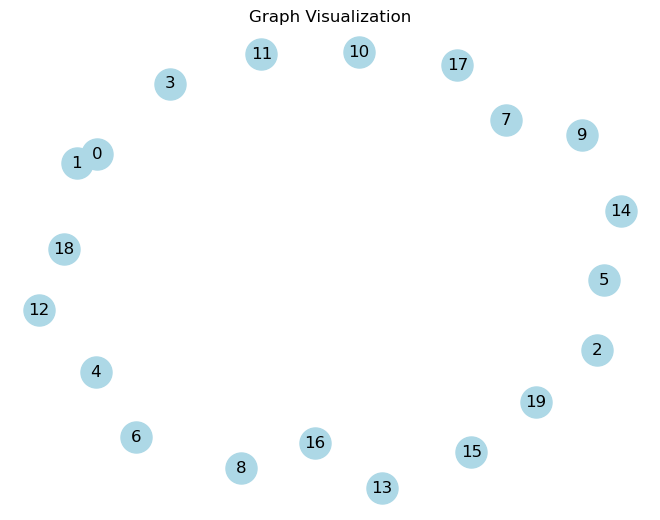

In [29]:
visualize_graph(graphs[3])

In [30]:
!pip install torch_geometric

In [31]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

In [32]:
import torch

# Example graph object from the user's data
graph = graphs[3]

# Extracting edge indices
edge_indices = graph.edge_index.t().tolist()

# Extracting node features (assuming each node has a feature vector)
node_features = graph.x.tolist()

# The nodes can be represented as a list of indices from 0 to the number of nodes - 1
node_indices = list(range(len(node_features)))

# Displaying the node indices and edge indices
#node_indices, edge_indices
#print(node_features)

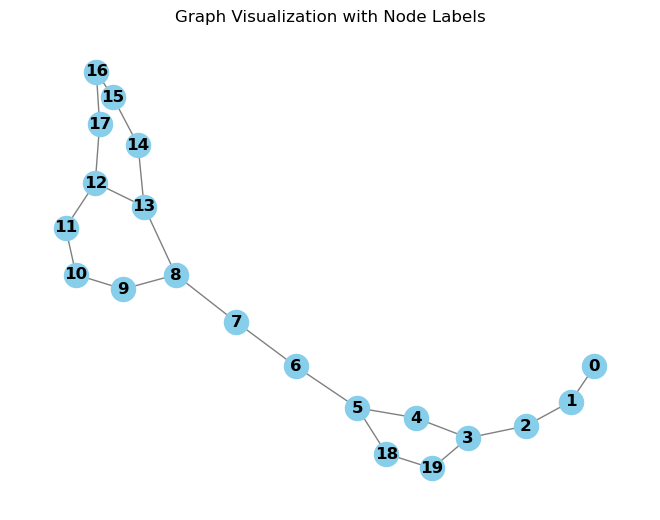

In [33]:
import networkx as nx
import torch_geometric

edge_index = torch.tensor(edge_indices, dtype=torch.long)
x = torch.tensor(node_indices, dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Draw the graph with node labels
pos = nx.spring_layout(g)  # Compute layout
nx.draw(g, pos, with_labels=True, font_weight='bold', node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization with Node Labels")
plt.show()

In [34]:
# Print the edge indices
print(graphs[3].edge_index.t().tolist())

[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 5, 18, 18, 19, 19, 3, 13, 8, 17, 12], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 5, 19, 18, 3, 19, 8, 13, 12, 17]]


In [35]:
# graphs[0] is a torch_geometric.data.Data object from your graphs list
graph = graphs[3]

# Print node features
print("Len of graph:", len(graph))
print("Node Features:")
print(len(graph.x))
#for i, node_feature in enumerate(graph.x):
    #print(f"Node {i}: {node_feature}")

# Print edge pairs and edge features
print("\nEdge Pairs and Features:")
print(graph.edge_index.t())
for i, edge in enumerate(graph.edge_index.t()):
    src, dest = edge[0].item(), edge[1].item()
    edge_feature = graph.edge_attr[i]
    #print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


Len of graph: 3
Node Features:
20

Edge Pairs and Features:
tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,  5, 18,
         18, 19, 19,  3, 13,  8, 17, 12],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18,  5,
         19, 18,  3, 19,  8, 13, 12, 17]])


In [36]:
# Extracting edge list and edge features from the provided graph
graph = graphs[5]  

# Extracting edge index
edge_index = graph.edge_index.t()

# Preparing the edge list
edge_list = []
for i in range(edge_index.shape[1]):
    edge = edge_index[:, i]
    edge_list.append((edge[0].item(), edge[1].item()))

edge_list


[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (7, 9),
 (9, 7),
 (9, 10),
 (10, 9),
 (1, 11),
 (11, 1),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (18, 17),
 (18, 19),
 (19, 18),
 (19, 20),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 21),
 (22, 23),
 (23, 22),
 (14, 24),
 (24, 14),
 (24, 25),
 (25, 24),
 (10, 4),
 (4, 10),
 (25, 11),
 (11, 25),
 (23, 15),
 (15, 23),
 (23, 18),
 (18, 23)]

In [37]:
import torch
from torch_geometric.data import Data

# Assuming graph_data is your list of graph objects
# graph_data[0] is the first graph object

# Select the first graph object
first_graph = graphs[3]

# Convert node features to a floating-point type if they aren't already
node_features_float = first_graph.x.float()

# Inspect node features
print("Node features (x) of the first graph:")
print(node_features_float)
print("Shape of node features:", node_features_float.shape)

# Inspect edge features
print("\nEdge features (edge_attr) of the first graph:")
print(first_graph.edge_attr)
print("Shape of edge features:", first_graph.edge_attr.shape)

# Inspect edge index (connectivity)
print("\nEdge index (edge_index) of the first graph:")
print(first_graph.edge_index)
print("Shape of edge index:", first_graph.edge_index.shape)

# Calculate min and max for each node feature of the first graph
min_values, max_values = node_features_float.min(dim=0)[0], node_features_float.max(dim=0)[0]

print("\nMinimum values of node features:", min_values)
print("Maximum values of node features:", max_values)

# Calculate the standard deviation for each node feature
std_deviation = node_features_float.std(dim=0)
print("\nStandard deviation of node features:", std_deviation)


Node features (x) of the first graph:
tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000, -0.3944],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0628],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0658],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0275],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1335],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0670]])
Shape of node features: torch.Size([20, 72])

Edge features (edge_attr) of the first graph:
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1.,

In [38]:
smiles_df['SMILES'][3]

'OCCn1cc(CNc2cccc3c2CCCC3)nn1'

In [39]:
mol = Chem.MolFromSmiles(smiles_df['SMILES'][3])
AllChem.ComputeGasteigerCharges(mol)

In [40]:
edge_indices = []
for bond in mol.GetBonds():
    start_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    edge_indices.append((start_idx, end_idx))
    edge_indices.append((end_idx, start_idx))  # Add the reverse direction


In [41]:
edge_indices

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (5, 18),
 (18, 5),
 (18, 19),
 (19, 18),
 (19, 3),
 (3, 19),
 (13, 8),
 (8, 13),
 (17, 12),
 (12, 17)]

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear

In [43]:
print((graphs[0]))
print((smiles_df.head(1)))

Data(x=[25, 72], edge_index=[54, 2], edge_attr=[54, 10])
                                   SMILES
0  CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1


In [44]:
print(len(graphs))
print(len(smiles_df))

402
402


In [45]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 402


In [46]:
smiles_df.head(5)

,SMILES
0,CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1,CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2,COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3,OCCn1cc(CNc2cccc3c2CCCC3)nn1
4,CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...


In [47]:
print(type(graphs[3]))

<class 'torch_geometric.data.data.Data'>


In [48]:
# Unsupervised Graph Generative Adversarial Netwrok

In [49]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [50]:
def generate_random_edge_index(num_nodes):
    # Example implementation to generate a random edge_index
    # Here we create a fully connected graph for simplicity
    edge_index = torch.combinations(torch.arange(num_nodes), r=2)
    return torch.cat([edge_index, edge_index.flip([1])], dim=0).t()  # Making it undirected

In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Data, Batch
from torch_geometric.utils import erdos_renyi_graph

def generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes):
    """
    Generate random noise for a batch of graphs with variable number of nodes and edges,
    but fixed node feature and edge feature dimensions.

    Args:
    - batch_size (int): Number of random graphs to generate.
    - node_feature_dim (int): Number of features for each node.
    - edge_feature_dim (int): Number of features for each edge.
    - max_num_nodes (int): Maximum number of nodes a graph can have.

    Returns:
    - A list of Data objects containing random noise for node and edge features.
    """
    random_graphs = []

    for _ in range(batch_size):
        # Randomly determine the number of nodes for this graph
        num_nodes = torch.randint(low=1, high=max_num_nodes, size=(1,)).item()

        # Generate random node features
        x = torch.randn(num_nodes, node_feature_dim)

        # Generate a random graph structure (edge_index)
        edge_index = erdos_renyi_graph(num_nodes, edge_prob=0.5)  # p is the probability of an edge

        # Generate random edge features (if needed)
        num_edges = edge_index.size(1)
        edge_attr = torch.randn(num_edges, edge_feature_dim) if edge_feature_dim > 0 else None

        # Create a Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        random_graphs.append(data)

    #return random_graphs
    return Batch.from_data_list(random_graphs)





In [52]:
# Example usage
batch_size = 32
node_feature_dim = 72  # Number of node features
edge_feature_dim = 10  # Number of edge features, adjust as needed
max_num_nodes = 50    # Maximum number of nodes in a graph

random_noise_graphs = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)

In [53]:
random_noise_graphs 

DataBatch(x=[831, 72], edge_index=[2, 13848], edge_attr=[13848, 10], batch=[831], ptr=[33])

In [54]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index gen",type(x), type(edge_index))
        #print("x, edge_index gen",x.size(), edge_index.size())
        #print("x, edge_index gen",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("Generator x layer 1:",x)
        x = torch.sigmoid(self.layer2(x, edge_index))
        #print("Generator x  layer 2:",x)
        return x

In [55]:
# Discriminator Model  
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        #print("In discriminator")
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("self.layer1",input_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        #print("self.layer2",hidden_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index1",type(x), type(edge_index))
        #print("x, edge_index2",x.size(), edge_index.size())
        #print("x, edge_index3",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("x 2",x)
        x = torch.sigmoid(self.layer2(x))
        #print("x 3",x)
        return x

In [56]:
# Model Initialization
generator_input_dim = 72
generator_hidden_dim = 256
#generator_hidden_dim = 128
generator_output_dim = 72

discriminator_input_dim = 72
discriminator_hidden_dim = 256
#discriminator_hidden_dim = 128

In [57]:
generator = Generator(generator_input_dim, generator_hidden_dim, generator_output_dim)
discriminator = Discriminator(discriminator_input_dim, discriminator_hidden_dim)

In [58]:
import torch.optim as optim
from torch_geometric.data import DataLoader
#from torch_geometric.loader import DataLoader

from torch.utils.data import Dataset

# Sample data loader (replace with your dataset)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=['x', 'edge_index'])
data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=[])



# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Loss function
adversarial_loss = torch.nn.BCELoss()

C:\Users\Malli\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [59]:
# Function to calculate discriminator accuracy
def calculate_discriminator_accuracy(discriminator, real_data, fake_data):
    real_predictions = discriminator(real_data).round()
    fake_predictions = discriminator(fake_data).round()
    correct_predictions = (real_predictions == 1).sum() + (fake_predictions == 0).sum()
    total_predictions = real_predictions.numel() + fake_predictions.numel()
    accuracy = 100 * correct_predictions.float() / total_predictions
    return accuracy

In [60]:
print((data_loader))

In [61]:
print((graphs[3].x).shape)
print((graphs[3].edge_index).shape)

torch.Size([20, 72])
torch.Size([44, 2])


In [62]:
print((graphs[0].x).shape)
print((graphs[0].edge_index).shape)

torch.Size([25, 72])
torch.Size([54, 2])


In [63]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch

def custom_graph_data_loader(graph_dataset, batch_size):
    """
    Custom data loader for graph data.
    
    Args:
    - graph_dataset (list of Data): The dataset containing graph Data objects.
    - batch_size (int): The size of each batch.

    Yields:
    - Batched Data object containing a batch of graphs.
    """

    def batch_graphs(graphs):
        """
        Manually batches a list of graphs into a single Batch object.
        """
        batched_edge_index = []
        batched_x = []
        batched_batch = []

        current_node_idx = 0
        for i, graph in enumerate(graphs):
            # Offset the node indices by the current_node_idx and add them to the batched edge index.
            #edge_index_offset = graph.edge_index + current_node_idx
            #batched_edge_index.append(edge_index_offset)
            
            # Offset only the node indices in the edge_index tensor.
            edge_index_offset = graph.edge_index.clone()  # Make a copy to avoid modifying the original graph
            edge_index_offset[0, :] += current_node_idx  # Offset source node indices
            edge_index_offset[1, :] += current_node_idx  # Offset target node indices
            #batched_edge_index.append(edge_index_offset)            
            
            #Tring edge_index
            #batched_edge_index.append(graph.edge_index)
            batched_edge_index.append(graph.edge_index + current_node_idx)

            # Add the current graph's node features to the batched node features.
            batched_x.append(graph.x)

            # Add the graph index to the batch vector for all nodes of this graph.
            batched_batch.append(torch.full((graph.x.size(0),), i, dtype=torch.long))

            # Update the current_node_idx for the next graph.
            current_node_idx += graph.x.size(0)

        # Concatenate all the lists to create tensors.       
        
        batched_edge_index = torch.cat(batched_edge_index, dim=0)
        batched_x = torch.cat(batched_x, dim=0)
        batched_batch = torch.cat(batched_batch, dim=0)
        

        # Create a new Data object to hold the batched graph.
        batched_data = Data(x=batched_x, edge_index=batched_edge_index)
        batched_data.batch = batched_batch

        return batched_data

    # Shuffle dataset at the beginning of each epoch
    indices = torch.randperm(len(graph_dataset))
    
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        batch_graphs_list = [graph_dataset[i] for i in batch_indices]
        batch = batch_graphs(batch_graphs_list)
        yield batch


In [64]:
num_epochs = 100
batch_size = 32
for epoch in range(num_epochs):
    print("epoch", epoch)
    for batch in custom_graph_data_loader(graphs, batch_size):
        # Generate fake data
        random_noise_graphs_batch = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)
        fake_x = generator(random_noise_graphs_batch)        

        # Ensure the edge_index is correctly shaped [2, num_edges]
        if batch.edge_index.size(0) != 2:
            batch.edge_index = batch.edge_index.t()  # Transpose if necessary

        # Create a fake data batch with both x and edge_index
        fake_data = Data(x=fake_x, edge_index=batch.edge_index)        

        # Labels for real and fake data (for each node)
        real_labels = torch.ones(batch.x.size(0), 1)
        fake_labels = torch.zeros(fake_x.size(0), 1)
        
        print("batch.x",batch.size())
        print("fake_data.x",fake_data.size())
        

        # Train Discriminator
        optimizer_D.zero_grad()
        dis_batch = discriminator(batch)
        #dis_fake = discriminator(fake_data)
        
        real_loss = adversarial_loss(dis_batch, real_labels)
        #print("real_loss :",real_loss)
        #fake_loss = adversarial_loss(dis_fake, fake_labels)
        
        #d_loss = real_loss + fake_loss
        d_loss = real_loss
        d_loss.backward()
        optimizer_D.step()


epoch 0
batch.x (768, 768)
fake_data.x (911, 911)
batch.x (765, 765)
fake_data.x (722, 722)
batch.x (806, 806)
fake_data.x (783, 783)
batch.x (886, 886)
fake_data.x (940, 940)
batch.x (776, 776)
fake_data.x (749, 749)
batch.x (719, 719)
fake_data.x (729, 729)
batch.x (751, 751)
fake_data.x (795, 795)
batch.x (745, 745)
fake_data.x (853, 853)
batch.x (820, 820)
fake_data.x (931, 931)
batch.x (989, 989)
fake_data.x (778, 778)
batch.x (724, 724)
fake_data.x (850, 850)
batch.x (782, 782)
fake_data.x (735, 735)
batch.x (375, 375)
fake_data.x (826, 826)
epoch 1
batch.x (736, 736)
fake_data.x (665, 665)
batch.x (793, 793)
fake_data.x (853, 853)
batch.x (816, 816)
fake_data.x (855, 855)
batch.x (808, 808)
fake_data.x (857, 857)
batch.x (737, 737)
fake_data.x (877, 877)
batch.x (768, 768)
fake_data.x (823, 823)
batch.x (755, 755)
fake_data.x (715, 715)
batch.x (863, 863)
fake_data.x (705, 705)
batch.x (810, 810)
fake_data.x (637, 637)
batch.x (742, 742)
fake_data.x (623, 623)
batch.x (777, 777)

batch.x (411, 411)
fake_data.x (796, 796)
epoch 15
batch.x (781, 781)
fake_data.x (853, 853)
batch.x (728, 728)
fake_data.x (765, 765)
batch.x (816, 816)
fake_data.x (870, 870)
batch.x (742, 742)
fake_data.x (831, 831)
batch.x (869, 869)
fake_data.x (760, 760)
batch.x (786, 786)
fake_data.x (880, 880)
batch.x (926, 926)
fake_data.x (826, 826)
batch.x (716, 716)
fake_data.x (848, 848)
batch.x (739, 739)
fake_data.x (747, 747)
batch.x (810, 810)
fake_data.x (812, 812)
batch.x (747, 747)
fake_data.x (770, 770)
batch.x (820, 820)
fake_data.x (877, 877)
batch.x (426, 426)
fake_data.x (902, 902)
epoch 16
batch.x (728, 728)
fake_data.x (731, 731)
batch.x (780, 780)
fake_data.x (897, 897)
batch.x (986, 986)
fake_data.x (829, 829)
batch.x (794, 794)
fake_data.x (853, 853)
batch.x (804, 804)
fake_data.x (925, 925)
batch.x (747, 747)
fake_data.x (1018, 1018)
batch.x (698, 698)
fake_data.x (701, 701)
batch.x (808, 808)
fake_data.x (775, 775)
batch.x (826, 826)
fake_data.x (687, 687)
batch.x (720, 

batch.x (814, 814)
fake_data.x (893, 893)
batch.x (768, 768)
fake_data.x (1021, 1021)
batch.x (751, 751)
fake_data.x (797, 797)
batch.x (786, 786)
fake_data.x (871, 871)
batch.x (684, 684)
fake_data.x (865, 865)
batch.x (810, 810)
fake_data.x (576, 576)
batch.x (863, 863)
fake_data.x (779, 779)
batch.x (804, 804)
fake_data.x (806, 806)
batch.x (777, 777)
fake_data.x (745, 745)
batch.x (779, 779)
fake_data.x (818, 818)
batch.x (727, 727)
fake_data.x (810, 810)
batch.x (752, 752)
fake_data.x (798, 798)
batch.x (591, 591)
fake_data.x (906, 906)
epoch 31
batch.x (790, 790)
fake_data.x (895, 895)
batch.x (970, 970)
fake_data.x (918, 918)
batch.x (709, 709)
fake_data.x (949, 949)
batch.x (770, 770)
fake_data.x (746, 746)
batch.x (703, 703)
fake_data.x (762, 762)
batch.x (710, 710)
fake_data.x (789, 789)
batch.x (787, 787)
fake_data.x (787, 787)
batch.x (775, 775)
fake_data.x (805, 805)
batch.x (826, 826)
fake_data.x (745, 745)
batch.x (880, 880)
fake_data.x (849, 849)
batch.x (814, 814)
fake

batch.x (807, 807)
fake_data.x (701, 701)
batch.x (768, 768)
fake_data.x (818, 818)
batch.x (738, 738)
fake_data.x (729, 729)
batch.x (687, 687)
fake_data.x (675, 675)
batch.x (782, 782)
fake_data.x (712, 712)
batch.x (925, 925)
fake_data.x (744, 744)
batch.x (811, 811)
fake_data.x (736, 736)
batch.x (725, 725)
fake_data.x (913, 913)
batch.x (782, 782)
fake_data.x (765, 765)
batch.x (462, 462)
fake_data.x (806, 806)
epoch 46
batch.x (925, 925)
fake_data.x (894, 894)
batch.x (763, 763)
fake_data.x (742, 742)
batch.x (808, 808)
fake_data.x (830, 830)
batch.x (739, 739)
fake_data.x (925, 925)
batch.x (790, 790)
fake_data.x (821, 821)
batch.x (755, 755)
fake_data.x (685, 685)
batch.x (780, 780)
fake_data.x (843, 843)
batch.x (828, 828)
fake_data.x (818, 818)
batch.x (791, 791)
fake_data.x (762, 762)
batch.x (726, 726)
fake_data.x (667, 667)
batch.x (796, 796)
fake_data.x (787, 787)
batch.x (779, 779)
fake_data.x (818, 818)
batch.x (426, 426)
fake_data.x (841, 841)
epoch 47
batch.x (744, 74

batch.x (808, 808)
fake_data.x (938, 938)
batch.x (793, 793)
fake_data.x (704, 704)
batch.x (833, 833)
fake_data.x (818, 818)
batch.x (766, 766)
fake_data.x (906, 906)
batch.x (836, 836)
fake_data.x (810, 810)
batch.x (709, 709)
fake_data.x (842, 842)
batch.x (428, 428)
fake_data.x (830, 830)
epoch 61
batch.x (736, 736)
fake_data.x (710, 710)
batch.x (823, 823)
fake_data.x (791, 791)
batch.x (874, 874)
fake_data.x (861, 861)
batch.x (929, 929)
fake_data.x (864, 864)
batch.x (743, 743)
fake_data.x (806, 806)
batch.x (780, 780)
fake_data.x (912, 912)
batch.x (709, 709)
fake_data.x (780, 780)
batch.x (819, 819)
fake_data.x (785, 785)
batch.x (811, 811)
fake_data.x (726, 726)
batch.x (757, 757)
fake_data.x (839, 839)
batch.x (775, 775)
fake_data.x (758, 758)
batch.x (783, 783)
fake_data.x (792, 792)
batch.x (367, 367)
fake_data.x (906, 906)
epoch 62
batch.x (729, 729)
fake_data.x (802, 802)
batch.x (778, 778)
fake_data.x (760, 760)
batch.x (853, 853)
fake_data.x (755, 755)
batch.x (845, 84

batch.x (878, 878)
fake_data.x (696, 696)
batch.x (795, 795)
fake_data.x (864, 864)
batch.x (763, 763)
fake_data.x (933, 933)
batch.x (755, 755)
fake_data.x (791, 791)
batch.x (769, 769)
fake_data.x (689, 689)
batch.x (544, 544)
fake_data.x (774, 774)
epoch 76
batch.x (779, 779)
fake_data.x (720, 720)
batch.x (735, 735)
fake_data.x (769, 769)
batch.x (845, 845)
fake_data.x (711, 711)
batch.x (811, 811)
fake_data.x (847, 847)
batch.x (717, 717)
fake_data.x (801, 801)
batch.x (795, 795)
fake_data.x (637, 637)
batch.x (714, 714)
fake_data.x (718, 718)
batch.x (792, 792)
fake_data.x (847, 847)
batch.x (788, 788)
fake_data.x (778, 778)
batch.x (745, 745)
fake_data.x (827, 827)
batch.x (781, 781)
fake_data.x (847, 847)
batch.x (1022, 1022)
fake_data.x (747, 747)
batch.x (382, 382)
fake_data.x (691, 691)
epoch 77
batch.x (753, 753)
fake_data.x (807, 807)
batch.x (847, 847)
fake_data.x (729, 729)
batch.x (769, 769)
fake_data.x (827, 827)
batch.x (872, 872)
fake_data.x (739, 739)
batch.x (808, 

batch.x (775, 775)
fake_data.x (836, 836)
batch.x (664, 664)
fake_data.x (860, 860)
batch.x (863, 863)
fake_data.x (901, 901)
batch.x (808, 808)
fake_data.x (920, 920)
batch.x (446, 446)
fake_data.x (850, 850)
epoch 91
batch.x (754, 754)
fake_data.x (967, 967)
batch.x (662, 662)
fake_data.x (691, 691)
batch.x (915, 915)
fake_data.x (857, 857)
batch.x (876, 876)
fake_data.x (751, 751)
batch.x (732, 732)
fake_data.x (752, 752)
batch.x (780, 780)
fake_data.x (685, 685)
batch.x (937, 937)
fake_data.x (811, 811)
batch.x (767, 767)
fake_data.x (700, 700)
batch.x (762, 762)
fake_data.x (742, 742)
batch.x (821, 821)
fake_data.x (750, 750)
batch.x (772, 772)
fake_data.x (655, 655)
batch.x (739, 739)
fake_data.x (886, 886)
batch.x (389, 389)
fake_data.x (751, 751)
epoch 92
batch.x (750, 750)
fake_data.x (846, 846)
batch.x (791, 791)
fake_data.x (696, 696)
batch.x (723, 723)
fake_data.x (898, 898)
batch.x (819, 819)
fake_data.x (782, 782)
batch.x (762, 762)
fake_data.x (851, 851)
batch.x (742, 74